# Mounting the drive

In [52]:
!pip install streamlit shap --quiet
import streamlit as st

In [53]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Loading the data

In [54]:
import pandas as pd

In [55]:
df = pd.read_csv('/content/drive/MyDrive/Deep Learning Class Project /archive (8)/loan_data.csv')

In [56]:
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [57]:
df.shape

(45000, 14)

In [58]:
df.columns

Index(['person_age', 'person_gender', 'person_education', 'person_income',
       'person_emp_exp', 'person_home_ownership', 'loan_amnt', 'loan_intent',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score', 'previous_loan_defaults_on_file', 'loan_status'],
      dtype='object')

In [59]:
# Count of each class in the target column
class_counts = df['loan_status'].value_counts()
print(class_counts)

# Percentage distribution
class_percent = df['loan_status'].value_counts(normalize=True) * 100
print("\nPercentage distribution:\n", class_percent)

loan_status
0    35000
1    10000
Name: count, dtype: int64

Percentage distribution:
 loan_status
0    77.777778
1    22.222222
Name: proportion, dtype: float64


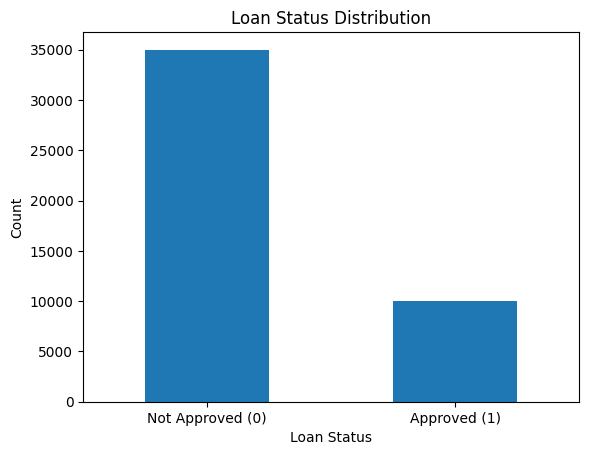

In [60]:
import matplotlib.pyplot as plt

class_counts.plot(kind='bar')
plt.title("Loan Status Distribution")
plt.xlabel("Loan Status")
plt.ylabel("Count")
plt.xticks(ticks=[0, 1], labels=["Not Approved (0)", "Approved (1)"], rotation=0)
plt.show()

# Preprocessing the data

In [61]:
# Importing the dependencies

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
import numpy as np

In [62]:
# === FEATURE ENGINEERING ===
df["debt_to_income"] = df["loan_amnt"] / (df["person_income"] + 1)
df["loan_burden_score"] = df["loan_int_rate"] * df["loan_percent_income"]
df["income_stability"] = df["person_income"] * (df["person_emp_exp"] + 1)
df["intent_edu"] = df["loan_intent"].astype(str) + "_" + df["person_education"].astype(str)
df["credit_income_ratio"] = df["credit_score"] / (df["person_income"] + 1)
df["exp_loan_ratio"] = (df["person_emp_exp"] + 1) / (df["loan_amnt"] + 1)
df["risk_score_est"] = df["credit_score"] * df["cb_person_cred_hist_length"]
df["income_per_year_exp"] = df["person_income"] / (df["person_emp_exp"] + 1)
df["ownership_income"] = df["person_home_ownership"].astype(str) + "_" + pd.qcut(df["person_income"], q=3, duplicates='drop').astype(str)

In [63]:
categorical_cols = ['person_gender', 'person_education', 'person_home_ownership',
                    'loan_intent', 'previous_loan_defaults_on_file', 'intent_edu', 'ownership_income']
for col in categorical_cols:
    df[col] = LabelEncoder().fit_transform(df[col].astype(str))


In [64]:
numerical_cols = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
                  'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score',
                  'debt_to_income', 'loan_burden_score', 'income_stability',
                  'credit_income_ratio', 'exp_loan_ratio', 'risk_score_est', 'income_per_year_exp']
df[numerical_cols] = StandardScaler().fit_transform(df[numerical_cols])

In [65]:
# Encode categorical features
label_encoders = {}

# Check for columns before applying LabelEncoding
categorical_cols_exist = [col for col in categorical_cols if col in df.columns]


for col in categorical_cols_exist:  # Process only existing columns
    # Label Encoding if column is of object type and has not been encoded yet
    if df[col].dtype == 'object' and col not in label_encoders:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le
    else:
        print(f"Column '{col}' has already been encoded or is not of object type. Skipping.")

Column 'person_gender' has already been encoded or is not of object type. Skipping.
Column 'person_education' has already been encoded or is not of object type. Skipping.
Column 'person_home_ownership' has already been encoded or is not of object type. Skipping.
Column 'loan_intent' has already been encoded or is not of object type. Skipping.
Column 'previous_loan_defaults_on_file' has already been encoded or is not of object type. Skipping.
Column 'intent_edu' has already been encoded or is not of object type. Skipping.
Column 'ownership_income' has already been encoded or is not of object type. Skipping.


# Splitting the data

In [66]:
# TRAIN-VALIDATION-TEST SPLIT
X = df.drop("loan_status", axis=1)
y = df["loan_status"]

In [67]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.3, random_state=42)


In [68]:

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values.astype(np.float32), dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values.astype(np.float32), dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values.astype(np.float32), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

In [69]:
# Class-weighted loss
weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train.values) # Convert classes to numpy array
weights = torch.tensor(weights, dtype=torch.float32)

In [70]:
def weighted_bce_loss(output, target):
    return - (weights[1] * target * torch.log(output + 1e-7) +
              weights[0] * (1 - target) * torch.log(1 - output + 1e-7)).mean()

In [71]:
# DataLoaders
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
val_ds = TensorDataset(X_val_tensor, y_val_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [72]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32)
test_dl = DataLoader(test_ds, batch_size=32)

# Building the neural network

In [73]:
class LoanClassifier(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.BatchNorm1d(256),       # ← BatchNorm
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(256, 128),
            nn.BatchNorm1d(128),       # ← BatchNorm
            nn.LeakyReLU(),
            nn.Dropout(0.3),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),        # ← BatchNorm
            nn.LeakyReLU(),

            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [74]:
# model = LoanClassifier(input_dim=X_train.shape[1])
# # loss_fn = nn.BCELoss()
# optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5, verbose=True)

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim

# === Model Instantiation ===
model = LoanClassifier(input_dim=X_train.shape[1])

# === Optimizer: AdamW with weight decay ===
optimizer = optim.AdamW(model.parameters(), lr=0.0005, weight_decay=1e-4)

# === Cosine Annealing Learning Rate Scheduler ===
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# === Focal Loss Implementation ===
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return focal_loss.mean()

# === Instantiate Focal Loss ===
loss_fn = FocalLoss(alpha=0.25, gamma=2)


In [76]:
# def train_model(model, train_dl, val_dl, loss_fn, optimizer, scheduler, epochs=50, patience=5):
#     best_val_loss = float('inf')
#     patience_counter = 0
#     best_model_state = None

#     for epoch in range(epochs):
#         model.train()
#         for xb, yb in train_dl:
#             pred = model(xb)
#             loss = loss_fn(pred, yb)
#             loss.backward()
#             optimizer.step()
#             optimizer.zero_grad()

#         model.eval()
#         with torch.no_grad():
#             val_losses = [loss_fn(model(xb), yb).item() for xb, yb in val_dl]
#             val_loss = sum(val_losses) / len(val_losses)
#         scheduler.step(val_loss)

#         print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")

#         if val_loss < best_val_loss:
#             best_val_loss = val_loss
#             best_model_state = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1
#             if patience_counter >= patience:
#                 print(f"Early stopping triggered at epoch {epoch+1}")
#                 break

#     if best_model_state:
#         model.load_state_dict(best_model_state)

In [77]:
def train_model(model, train_dl, val_dl, loss_fn, optimizer, scheduler, epochs=50, patience=5):
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_state = None

    val_losses = []  # Track validation loss over time

    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        model.eval()
        with torch.no_grad():
            val_batch_losses = [loss_fn(model(xb), yb).item() for xb, yb in val_dl]
            val_loss = sum(val_batch_losses) / len(val_batch_losses)

        val_losses.append(val_loss)  # Track validation loss
        scheduler.step()

        print(f"Epoch {epoch+1}: Validation Loss = {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    if best_model_state:
        model.load_state_dict(best_model_state)

    return val_losses  # Add return so you can plot it


In [78]:
val_losses = train_model(model, train_dl, val_dl, loss_fn, optimizer, scheduler)


Epoch 1: Validation Loss = 0.0154
Epoch 2: Validation Loss = 0.0139
Epoch 3: Validation Loss = 0.0135
Epoch 4: Validation Loss = 0.0131
Epoch 5: Validation Loss = 0.0132
Epoch 6: Validation Loss = 0.0131
Epoch 7: Validation Loss = 0.0130
Epoch 8: Validation Loss = 0.0128
Epoch 9: Validation Loss = 0.0128
Epoch 10: Validation Loss = 0.0128
Epoch 11: Validation Loss = 0.0129
Epoch 12: Validation Loss = 0.0128
Epoch 13: Validation Loss = 0.0128
Epoch 14: Validation Loss = 0.0129
Early stopping triggered at epoch 14


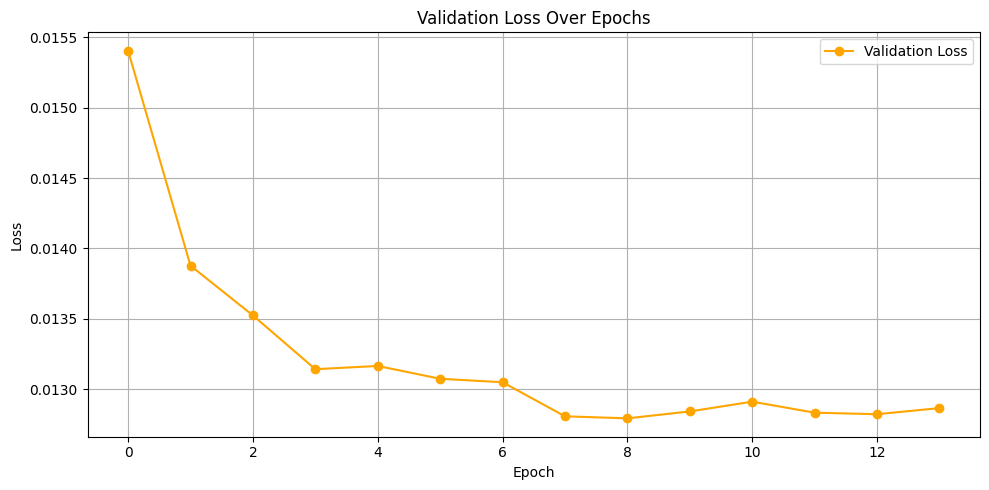

In [79]:
#Plot Validation Loss Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(val_losses, label="Validation Loss", marker='o', color='orange')
plt.title("Validation Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Evaluation

In [80]:
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)

#FIND BEST THRESHOLD BASED ON F1
best_f1, best_threshold = 0, 0
for t in np.arange(0.3, 0.71, 0.01):
    y_pred = (y_pred_probs > t).float()
    f1 = f1_score(y_test_tensor.numpy(), y_pred.numpy())
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = t

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1 Score: {best_f1:.2f}")


# Get predictions from the model for the test data
model.eval()
with torch.no_grad():
    y_pred_probs = model(X_test_tensor)
    y_pred = (y_pred_probs > 0.5).float()  # Assuming 0.5 as the threshold for binary classification

# Convert tensors to NumPy arrays for sklearn functions
y_test_np = y_test_tensor.numpy().flatten()
y_pred_np = y_pred.numpy().flatten()

# Calculate and print metrics
print(f"Accuracy: {accuracy_score(y_test_np, y_pred_np)}")
print(f"Precision: {precision_score(y_test_np, y_pred_np)}")
print(f"Recall: {recall_score(y_test_np, y_pred_np)}")
print(f"F1 Score: {f1_score(y_test_np, y_pred_np)}")



Best Threshold: 0.47, Best F1 Score: 0.79
Accuracy: 0.9094444444444445
Precision: 0.8317601332593004
Recall: 0.745273631840796
F1 Score: 0.7861453686696405


In [81]:
y_pred_final = (y_pred_probs > best_threshold).float()
acc = accuracy_score(y_test_tensor.numpy(), y_pred_final.numpy())
prec = precision_score(y_test_tensor.numpy(), y_pred_final.numpy())
rec = recall_score(y_test_tensor.numpy(), y_pred_final.numpy())
f1 = f1_score(y_test_tensor.numpy(), y_pred_final.numpy())
print(f"Accuracy: {acc:.2f}, Precision: {prec:.2f}, Recall: {rec:.2f}, F1: {f1:.2f}")

Accuracy: 0.91, Precision: 0.80, Recall: 0.79, F1: 0.79


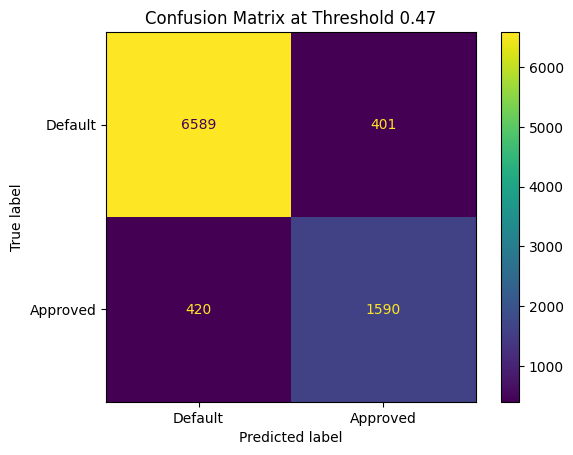

In [82]:
cm = confusion_matrix(y_test_tensor.numpy(), y_pred_final.numpy())
disp = ConfusionMatrixDisplay(cm, display_labels=["Default", "Approved"])
disp.plot()
plt.title(f"Confusion Matrix at Threshold {best_threshold:.2f}")
plt.show()

# Explainability

In [83]:
!pip install lime --quiet



In [84]:
!pip install ipywidgets --quiet

In [86]:
from lime.lime_tabular import LimeTabularExplainer
import numpy as np
import torch

# === Step 1: Prepare Data for LIME ===
X_train_lime = X_train.values.astype(np.float32)
X_test_lime = X_test.values.astype(np.float32)

# === Step 2: Define Prediction Function for LIME ===
def predict_fn(input_array):
    input_tensor = torch.tensor(input_array, dtype=torch.float32)
    with torch.no_grad():
        probs = model(input_tensor).numpy()  # shape (N, 1)
    return np.stack([1 - probs[:, 0], probs[:, 0]], axis=1)

# === Step 3: Initialize LIME Explainer ===
explainer = LimeTabularExplainer(
    training_data=X_train_lime,
    feature_names=X_train.columns.tolist(),
    class_names=["Default", "Approved"],
    mode="classification",
    discretize_continuous=True
)

# === Step 4: Explain a Single Test Prediction ===
sample_index = 5  # Change this index to explain other samples

explanation = explainer.explain_instance(
    data_row=X_test_lime[sample_index],
    predict_fn=predict_fn,
    num_features=10
)

# === Step 5: Display Explanation (Text-Based, Colab-Compatible) ===
print(f"\n🔍 LIME Explanation for Test Sample #{sample_index}")
for feature, weight in explanation.as_list():
    print(f"{feature:<50} → {weight:+.4f}")



🔍 LIME Explanation for Test Sample #5
previous_loan_defaults_on_file <= 0.00             → +0.4136
loan_int_rate <= -0.82                             → -0.0549
credit_income_ratio > 0.38                         → +0.0477
person_age > 0.37                                  → +0.0304
0.00 < person_home_ownership <= 3.00               → +0.0255
0.15 < credit_score <= 0.74                        → -0.0138
3.00 < loan_intent <= 4.00                         → +0.0076
cb_person_cred_hist_length > 0.55                  → +0.0076
-0.23 < person_emp_exp <= 0.43                     → -0.0068
-0.09 < income_stability <= -0.06                  → -0.0059


The model explains:

1. condition = how the value for this feature compares to LIME's threshold

2. weight = how much this feature pushed the prediction up (positive) or down (negative)

Breakdown:
Feature	- Meaning -	Influence

- previous_loan_defaults_on_file <= 0.00	No previous default → strongly supports approval	+0.44

- loan_int_rate <= -0.82	Very low interest rate → supports approval	-0.08

- credit_income_ratio > 0.38	High credit score compared to income → supports approval	+0.06

- person_home_ownership <= 3.00	Likely renting/mortgage vs owned outright → mild influence	+0.04

- person_age > 0.37	Older borrower (normalized scale) → slightly supports approval	+0.02

- loan_intent & credit_score	Small positive/negative influence (these features are more balanced)	±0.01

- exp_loan_ratio > 0.10	Not useful — weight = 0.00 means it had no effect	 No impact



Most important feature: previous_loan_defaults_on_file (absence of default strongly increased approval)

Model decision driver: Mostly credit health and risk flags

Some features (like exp_loan_ratio) had no effect on this prediction